# Inference Kernel Demo

This is the kernel I’ve used for my recent submissions. It takes about 5-6 hours on the test set, using only CPU. 

I’ve provided this kernel because a lot of people have problems making submissions. This method works and has never errored out for me. (Although I haven't tried making a submission using the GPU yet -- so no guarantees there.)

It uses BlazeFace for face extraction (see also [my BlazeFace kernel](https://www.kaggle.com/humananalog/starter-blazeface-pytorch)) and ResNeXt50 as the classifier model.

We take the average prediction over 17 frames from each video. (Why 17? Using more frames makes the kernel slower, but doesn't appear to improve the score much. I used an odd number so we don't always land on even frames.)

**Please use this kernel only to learn from...** Included is the checkpoint for a ResNeXt50 model that hasn't really been trained very well yet. I'm sure you can improve on it by training your own model!

You could use the included trained weights to get yourself an easy top-50 score on the leaderboard (as of 24 Jan 2020) but it’s nicer to use it as a starting point for your own work. :-)

In [1]:
import os, sys, time
import cv2
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.nn.functional as F

%matplotlib inline
import matplotlib.pyplot as plt
from torchvision.models.resnet import ResNet, Bottleneck


In [2]:
for root, dirs, fns in os.walk('/kaggle'):
    for fn in fns:
        print(os.path.join(root,fn))
        

/kaggle/src/script.ipynb
/kaggle/lib/kaggle/gcp.py
/kaggle/input/deepfakes-inference-demo/resnext.pth
/kaggle/input/deepfakes-inference-demo/helpers/face_extract_1.py
/kaggle/input/deepfakes-inference-demo/helpers/read_video_1.py
/kaggle/input/surrenderanddie/resnext_clip_norm_loss_0.11215515261314458_acc_0(1).9575268068514134
/kaggle/input/deepfake-detection-challenge/sample_submission.csv
/kaggle/input/deepfake-detection-challenge/test_videos/nplviymzlg.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/qlvsqdroqo.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/yhylappzid.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/elackxuccp.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/csnkohqxdv.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/hzoiotcykp.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/nwvloufjty.mp4
/kaggle/input/deepfake-detection-challenge/test_videos/sodvtfqbpf.mp4
/kaggle/input/deepfake-detection-challenge/tes

In [3]:
import sys
sys.path.insert(0,'/kaggle/input/pretrainedmodelspytorch/pretrained-models.pytorch-master/')

import pretrainedmodels

## Get the test videos

In [4]:
test_dir = "/kaggle/input/deepfake-detection-challenge/test_videos/"

test_videos = sorted([x for x in os.listdir(test_dir) if x[-4:] == ".mp4"])
len(test_videos)

400

## Create helpers

In [5]:
print("PyTorch version:", torch.__version__)
print("CUDA version:", torch.version.cuda)
print("cuDNN version:", torch.backends.cudnn.version())

PyTorch version: 1.3.0
CUDA version: 10.0.130
cuDNN version: 7603


In [6]:
gpu = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
gpu

device(type='cuda', index=0)

In [7]:
import sys
sys.path.insert(0, "/kaggle/input/blazeface-pytorch")
sys.path.insert(0, "/kaggle/input/deepfakes-inference-demo")


In [8]:
from blazeface import BlazeFace
facedet = BlazeFace().to(gpu)
facedet.load_weights("/kaggle/input/blazeface-pytorch/blazeface.pth")
facedet.load_anchors("/kaggle/input/blazeface-pytorch/anchors.npy")
_ = facedet.train(False)

In [9]:
from helpers.read_video_1 import VideoReader
from helpers.face_extract_1 import FaceExtractor

frames_per_video = 30

video_reader = VideoReader()
video_read_fn = lambda x: video_reader.read_frames(x, num_frames=frames_per_video)
face_extractor = FaceExtractor(video_read_fn, facedet)

In [10]:
input_size = 224

In [11]:
from torchvision.transforms import Normalize

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
normalize_transform = Normalize(mean, std)

In [12]:
def isotropically_resize_image(img, size, resample=cv2.INTER_AREA):
    h, w = img.shape[:2]
    if w > h:
        h = h * size // w
        w = size
    else:
        w = w * size // h
        h = size

    resized = cv2.resize(img, (w, h), interpolation=resample)
    return resized


def make_square_image(img):
    h, w = img.shape[:2]
    size = max(h, w)
    t = 0
    b = size - h
    l = 0
    r = size - w
    return cv2.copyMakeBorder(img, t, b, l, r, cv2.BORDER_CONSTANT, value=0)

In [13]:
import sys
sys.path.insert(0, '/kaggle/input/efficientnet/EfficientNet-PyTorch-master')

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from efficientnet_pytorch import EfficientNet
#model = torch.hub.load('facebookresearch/WSL-Images', 'resnext101_32x8d_wsl')



class FinalClassifier(torch.nn.Module):
    def __init__(self):
        super(FinalClassifier, self).__init__()
        self.fc1 = nn.Linear(1000, 100)
        self.fc2 = nn.Linear(100, 100)
        self.fc3 = nn.Linear(100, 1)
        self.drop = nn.Dropout(p=0.4)
    def forward(self, inputs):
        x = self.drop(F.relu(self.fc1(inputs)))
        x = self.drop(F.relu(self.fc2(x)))
        return F.sigmoid(self.fc3(x))

kwargs = {}
kwargs['groups'] = 32
kwargs['width_per_group'] = 8

model1 = ResNet(Bottleneck, [3, 4, 23, 3], **kwargs).to('cuda')

my_fc1 = FinalClassifier()

f_model1 = nn.Sequential(model1, my_fc1 ).to('cuda')

checkpoint1 = torch.load('/kaggle/input/surrenderanddie/resnext_clip_norm_loss_0.11215515261314458_acc_0(1).9575268068514134')
f_model1.load_state_dict(checkpoint1)
del checkpoint1
'''

model2 = EfficientNet.from_name('efficientnet-b7')
my_fc2 = FinalClassifier()
if torch.cuda.is_available():
    model2.to('cuda')
    f_model2 = nn.Sequential(model2, my_fc2 ).to('cuda')
    
checkpoint2 = torch.load('/kaggle/input/inhuman/efficientnet-b7-clip-norm-7')
f_model2.load_state_dict(checkpoint2)
del checkpoint2
'''

model2 = pretrainedmodels.__dict__['xception'](num_classes=1000, pretrained=None) 
my_fc2 = FinalClassifier()
if torch.cuda.is_available():
    model2.to('cuda')
    f_model2 = nn.Sequential(model2, my_fc2 ).to('cuda')
    
checkpoint2 = torch.load('/kaggle/input/xceptionweirdest/xception-weirdest')
f_model2.load_state_dict(checkpoint2)
del checkpoint2

model3 = EfficientNet.from_name('efficientnet-b7')
my_fc3 = FinalClassifier()
if torch.cuda.is_available():
    model3.to('cuda')
    f_model3 = nn.Sequential(model3, my_fc3 ).to('cuda')
    
checkpoint3 = torch.load('/kaggle/input/inhuman/efficientnet-b7-clip-norm-7')
f_model3.load_state_dict(checkpoint3)
del checkpoint3


model4 = pretrainedmodels.__dict__['se_resnext101_32x4d'](num_classes=1000, pretrained=None) 
my_fc4 = FinalClassifier()
if torch.cuda.is_available():
    model4.to('cuda')
    f_model4 = nn.Sequential(model4, my_fc4 ).to('cuda')
    
checkpoint4 = torch.load('/kaggle/input/seresnext101/seresnext101-weird-2')
f_model4.load_state_dict(checkpoint4)
del checkpoint4


f_model1.eval()
f_model2.eval()
f_model3.eval()
f_model4.eval()

Sequential(
  (0): SENet(
    (layer0): Sequential(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu1): ReLU(inplace=True)
      (pool): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=True)
    )
    (layer1): Sequential(
      (0): SEResNeXtBottleneck(
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(128, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU

In [15]:
'''
sys.path.insert(0,'/kaggle/input/onnx2keras/onnx2keras-0.0.18/')
f_modelx = nn.Sequential(*[f_model1[i] for i in range(1)])
from torch.autograd import Variable

dummy = Variable(torch.Tensor(np.zeros((1, 3, 224,224))))
from pytorch2keras import pytorch_to_keras
k_model = pytorch_to_keras(f_modelx, dummy, [( 3,224,224)], verbose=False)  

from tensorflow.keras.layers import *
inp = Input((15,3, 224, 224))
inp_mask = Input((15,1))
out = TimeDistributed(k_model, input_shape=(3,224,224)) (inp)

out = Multiply()([out, inp_mask])
out = Masking(mask_value=0.0)(out)
out = Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25))(out) #0.6
out = Dense(64, activation='elu')(out)
out = Dense(1,activation='sigmoid')(out)

from tensorflow.keras import Model, Sequential
model = Model([inp, inp_mask],out)
for layer in k_model.layers:
    layer.trainable=False
model.summary()
model.load_weights('/kaggle/input/astraseason/lstm-128-sgd-weights-1.h5')
'''

"\nsys.path.insert(0,'/kaggle/input/onnx2keras/onnx2keras-0.0.18/')\nf_modelx = nn.Sequential(*[f_model1[i] for i in range(1)])\nfrom torch.autograd import Variable\n\ndummy = Variable(torch.Tensor(np.zeros((1, 3, 224,224))))\nfrom pytorch2keras import pytorch_to_keras\nk_model = pytorch_to_keras(f_modelx, dummy, [( 3,224,224)], verbose=False)  \n\nfrom tensorflow.keras.layers import *\ninp = Input((15,3, 224, 224))\ninp_mask = Input((15,1))\nout = TimeDistributed(k_model, input_shape=(3,224,224)) (inp)\n\nout = Multiply()([out, inp_mask])\nout = Masking(mask_value=0.0)(out)\nout = Bidirectional(LSTM(128, dropout=0.25, recurrent_dropout=0.25))(out) #0.6\nout = Dense(64, activation='elu')(out)\nout = Dense(1,activation='sigmoid')(out)\n\nfrom tensorflow.keras import Model, Sequential\nmodel = Model([inp, inp_mask],out)\nfor layer in k_model.layers:\n    layer.trainable=False\nmodel.summary()\nmodel.load_weights('/kaggle/input/astraseason/lstm-128-sgd-weights-1.h5')\n"

In [16]:
'''
if torch.cuda.is_available():
    model1.to('cuda')
    f_model1 = nn.Sequential(model2, my_fc2 ).to('cuda')
'''

"\nif torch.cuda.is_available():\n    model1.to('cuda')\n    f_model1 = nn.Sequential(model2, my_fc2 ).to('cuda')\n"

In [17]:
def get_brightness(img):
    return img/img.max()

In [18]:
from torchvision import transforms
preprocess2 = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

In [19]:
preprocess_icp = transforms.Compose([
    transforms.Resize(299),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    
])

## Prediction loop

In [20]:
import gc
def predict_on_video(video_path, batch_size):
    try:
        # Find the faces for N frames in the video.
        faces = face_extractor.process_video(video_path)

        # Only look at one face per frame.
        face_extractor.keep_only_best_face(faces)
        
        if len(faces) > 0:
            # NOTE: When running on the CPU, the batch size must be fixed
            # or else memory usage will blow up. (Bug in PyTorch?)
            x = []
            x_flipped = []
            x_icp = []
            x_flipped_icp = []

            # If we found any faces, prepare them for the model.
            n = 0

            for frame_data in faces:
               
                for face in frame_data["faces"]:
                    # Resize to the model's required input size.
                    # We keep the aspect ratio intact and add zero
                    # padding if necessary.                    
                    resized_face = isotropically_resize_image(face, input_size)
                    resized_face = make_square_image(resized_face)
                    flipped_face = preprocess2(cv2.flip(resized_face, 1))
                    resized_face = preprocess2(resized_face)
                    x.append(resized_face)
                    x_flipped.append(flipped_face)
                
                    

                  
                    
    
         
            x = torch.stack(x)
            x_flipped = torch.stack(x_flipped)

          
            # Make a prediction, then take the average.
            with torch.no_grad():
                y_pred1 = 0.5* np.median(f_model1(x.to(gpu)).cpu().numpy()) + 0.5* np.median(f_model1(x_flipped.to(gpu)).cpu().numpy())
                y_pred2 = 0.5 * np.median(f_model2(x.to(gpu)).cpu().numpy()) + 0.5* np.median(f_model2(x_flipped.to(gpu)).cpu().numpy())
                y_pred3 = 0.5 * np.median(f_model3(x.to(gpu)).cpu().numpy()) + 0.5* np.median(f_model3(x_flipped.to(gpu)).cpu().numpy())
                y_pred4 = 0.5 * np.median(f_model4(x.to(gpu)).cpu().numpy()) + 0.5* np.median(f_model4(x_flipped.to(gpu)).cpu().numpy())
                gc.collect()
                torch.cuda.empty_cache()
                gc.collect()
                fin = 0.2*y_pred1 + 0.5*y_pred4  + 0.15*y_pred3 + 0.15*y_pred2
                
         
                
     


                return fin


    except Exception as e:
        print("Prediction error on video %s: %s" % (video_path, str(e)))

    return 0.55

In [21]:
from concurrent.futures import ThreadPoolExecutor

def predict_on_video_set(videos, num_workers):
    def process_file(i):
        filename = videos[i]
        y_pred = predict_on_video(os.path.join(test_dir, filename), batch_size=frames_per_video)
        return y_pred

    with ThreadPoolExecutor(max_workers=num_workers) as ex:
        predictions = ex.map(process_file, range(len(videos)))

    return list(predictions)

## Speed test

The leaderboard submission must finish within 9 hours. With 4000 test videos, that is `9*60*60/4000 = 8.1` seconds per video. So if the average time per video is greater than ~8 seconds, the kernel will be too slow!

In [22]:
speed_test = True # you have to enable this manually

In [23]:
if speed_test:
    start_time = time.time()
    speedtest_videos = test_videos[:5]
    predictions = predict_on_video_set(speedtest_videos, num_workers=4)
    elapsed = time.time() - start_time
    print("Elapsed %f sec. Average per video: %f sec." % (elapsed, elapsed / len(speedtest_videos)))

/opt/conda/lib/python3.6/site-packages/torch/nn/functional.py:1351: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Elapsed 25.341107 sec. Average per video: 5.068221 sec.


In [24]:
predictions

[0.5468905180692673,
 0.0005147977634806011,
 0.7071682661771774,
 0.0014562494037818397,
 0.9874169632792473]

## Make the submission

In [25]:
predictions = predict_on_video_set(test_videos, num_workers=4)


Prediction error on video /kaggle/input/deepfake-detection-challenge/test_videos/imdmhwkkni.mp4: stack expects a non-empty TensorList
Prediction error on video /kaggle/input/deepfake-detection-challenge/test_videos/lbigytrrtr.mp4: stack expects a non-empty TensorList


In [26]:
submission_df = pd.DataFrame({"filename": test_videos, "label": predictions})
submission_df.to_csv("submission.csv", index=False)

(array([124.,  24.,  17.,  22.,  28.,  37.,  23.,  18.,  30.,  77.]),
 array([2.10486713e-04, 9.96680101e-02, 1.99125533e-01, 2.98583057e-01,
        3.98040580e-01, 4.97498103e-01, 5.96955627e-01, 6.96413150e-01,
        7.95870673e-01, 8.95328197e-01, 9.94785720e-01]),
 <a list of 10 Patch objects>)

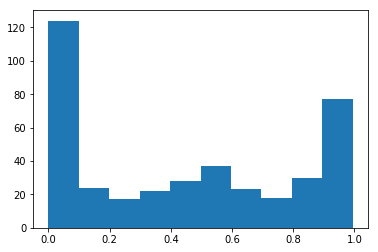

In [27]:
plt.hist(submission_df['label'])

In [28]:


np.array(submission_df['label']).mean()


0.4467589114075888